In [1]:
import os
from datetime import datetime
import argparse
from msprime_models import * 
# from abinitio_tm import scaled_time_intervals
# from msprime_utils import scaled_time_intervals, get_het, round_coal_times, tm_counts, get_coal_data, round_bin_coal_data, normalise
from msprime_utils import *
from heatmaps_generate import *
from vcf_mhs import *
import numpy as np
import pdb
import math
import pandas as pd
from scipy.stats import entropy
import argparse
import matplotlib.pyplot as plt
import numpy as np


In [3]:
# pecify the paramaters you want. Defaults as below

parser = argparse.ArgumentParser()
parser.add_argument("model",help="Specify the model to be used, as defined in msprime_models.")
parser.add_argument("-N","--N_0",help="Initial population size (Default is 1e+04",default=1e+04,type=int)
parser.add_argument("-L","--seq_length",help="Length of the sequence to be simulated (default 3e+07)",default=int(3e+07),type=int)
parser.add_argument("-mig","--migration_prop",help="Proportion of migrating population (default 0.3)",default=0.3,type=float)
parser.add_argument("-t","--time_splits",nargs=2,help="Time of splits, in generations (default t_1 = 2e+04, t_2 = 4e+04)",default = [int(2e+04),int(4e+04)])
parser.add_argument("-bin","--bin_length",help="The length (in bases) of the how wide you want each bin. (Default is 100)",default=100,type=int)
parser.add_argument("-o_coaldir","--output_coaldir",help="Output directory of coalescent data",default=os.getcwd() + '/coal_data/',type=str)
parser.add_argument("-o_coalname","--output_coalname",help="Output name for coal_data filename",default='',type=str)
parser.add_argument("-o_mhsdir","--output_mhsdir",help="Output dir for vcf and mhs data",default=os.getcwd() + '/vcf_mhs/',type=str)
parser.add_argument("-o_mhsname","--output_mhsname",help="Output name for vcf and mhs data",default = '',type=str)
parser.add_argument("-rho","--recomb_rate",help="Rate of recombination per bp per generation",default=2e-08,type=float)
parser.add_argument("-mew","--mut_rate",help="Rate of mutation per bp per generation",default=2e-08,type=float)
parser.add_argument("--suffix_time",help="Boolean, whether to write the time in to the files (useful for multi runs of the same simulation",action="store_true")
parser.add_argument("--print",help="Print the DemographicDebugger (from msprime) and the number of segratating sites",action="store_true")
parser.add_argument("--tree",help="Draw trees and info per segment",action="store_true")
args = parser.parse_args("m0001".split())

In [4]:
path =  '/home/trevor/ancestry/coal_data/mig01/'
files = os.listdir(path)
print(f'files are {files}')
test = np.loadtxt(path+files[0],comments="#")
seq_length = 150e+06 * len(files)



files are ['20201127_instant_struct0001_mig1_093903.txt', '20201127_instant_struct0001_mig1_094150.txt', '20201127_instant_struct0001_mig1_094432.txt', '20201127_instant_struct0001_mig1_094722.txt', '20201127_instant_struct0001_mig1_095007.txt', '20201127_instant_struct0001_mig1_095250.txt', '20201127_instant_struct0001_mig1_095527.txt', '20201127_instant_struct0001_mig1_095814.txt', '20201127_instant_struct0001_mig1_100053.txt', '20201127_instant_struct0001_mig1_100332.txt', '20201127_instant_struct0001_mig1_100607.txt', '20201127_instant_struct0001_mig1_100851.txt', '20201127_instant_struct0001_mig1_101136.txt', '20201127_instant_struct0001_mig1_101414.txt', '20201127_instant_struct0001_mig1_101649.txt', '20201127_instant_struct0001_mig1_101923.txt', '20201127_instant_struct0001_mig1_102203.txt', '20201127_instant_struct0001_mig1_102443.txt', '20201127_instant_struct0001_mig1_102724.txt', '20201127_instant_struct0001_mig1_102955.txt', '20201127_instant_struct0001_mig1_123359.txt', '2

In [5]:
# scaled_time_intervals 
mu = 2e-08
alpha = 0.1
N_0 = 10000 # TODO, use sim
Tmax = 15
N_T = 50
T = [0]
for i in range(0,N_T): # TODO: should T have upper interval
        T.append( alpha*math.exp( (i/N_T)*math.log(1 + Tmax/alpha) - 1))
T_np = np.array(T) # convert to numpy
# scale these to generations with *2*N_0, as per Schiffels' instruction
T_scaled_np = T_np * 2 * N_0

# print(f'T_scaled_np {T_scaled_np}')
coal_times = round_bin_coal_data(seq_length,test, args)
# print(coal_times[0:200])
# coal_times_intervals = round_coal_times(coal_times,T_scaled_np,N_T)

np.where(coal_times==0) # gives 150000
temp_coal_times = coal_times[0:1500000]
# print(f'coal_times {coal})

In [6]:
coal_times_intervals = []
for i in range(len(temp_coal_times)):
    diff = temp_coal_times[i] - T_scaled_np
    diff_pos = diff[diff >0]
    where = np.argmin(diff_pos) # find closest interval
    if where == N_T: #TODO find a better fix for this. Have extended T to include upper interval
        where = where - 1
    coal_times_intervals.append(where) 

# np.where(temp_coal_times==0)

/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


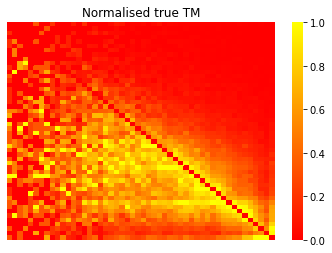

In [7]:
coal_times_intervals
tm = tm_counts(coal_times_intervals,N_T=N_T)
tm_norm = normalise(tm,'colsum') # normalise this such that it represents a probability distribution

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd = np.copy(tm)
tm_nd[range(0,len(tm)),range(0,len(tm))] = 0
tm_nd_norm = normalise(tm_nd,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

# TODO left-most and upper-most column look strange - try and fix. Update, think this is ok
heatmaps_seq(normalise(tm_nd,'colmax'),title='Normalised true TM') # show heatmap